# Response criteria prediction for tumor
Sam Tomioka<br>
2019-09-27

This notebook is for PhUSE AI/ML Project Tumor response prediction challenge

## 1 - Import libraries

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split\
, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

from lib import myutil
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
%matplotlib inline

print('sklearn=={}\nxgboost=={}'.format(sklearn.__version__,xgb.__version__))

sklearn==0.21.1
xgboost==0.90


## 2 - Import data

In [2]:
traindf=pd.read_excel(os.path.join('..','data','dummyTGR2.xlsx'))

traindf.dropna(inplace=True)
traindf.shape

(9000, 8)

In [3]:
traindf.head()

,SUMLDIAM,SUMNLNLD,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,TRGRESP
1,48,7,55,-55,122,-67,-55,PR
2,10,7,17,-86,55,-38,-69,PR
3,27,9,36,-70,17,19,112,PD
4,7,0,7,-94,17,-10,-59,PR
5,0,0,0,-100,7,-7,-100,CR


- class variable: `TRGRESP`
- Other columns are features

## 3 - Check missing

In [4]:
for c in traindf.columns:
    print ('Number of missing in {}: {}'\
           .format(c, len(traindf[traindf[c].isnull()])))

Number of missing in SUMLDIAM: 0
Number of missing in SUMNLNLD: 0
Number of missing in SUMDIAM: 0
Number of missing in PCBSD: 0
Number of missing in NADIR: 0
Number of missing in ACNSD: 0
Number of missing in PCNSD: 0
Number of missing in TRGRESP: 0


## 4 - check distribution

### - class variable

In [5]:
dist=traindf['TRGRESP'].value_counts()/len(traindf['TRGRESP'])
dist

PD    0.316222
PR    0.305000
CR    0.253444
SD    0.125333
Name: TRGRESP, dtype: float64

In [6]:
n_class=4
weight_dict={'PD': (1/n_class)/dist[0]
            ,'PR': (1/n_class)/dist[1]
            ,'CR': (1/n_class)/dist[2] 
            ,'SD': (1/n_class)/dist[3]
            }
wt = traindf['TRGRESP'].map(weight_dict)

May need to adjust the imbalance

### - covariates (features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000014705B51358>,
      dtype=object)

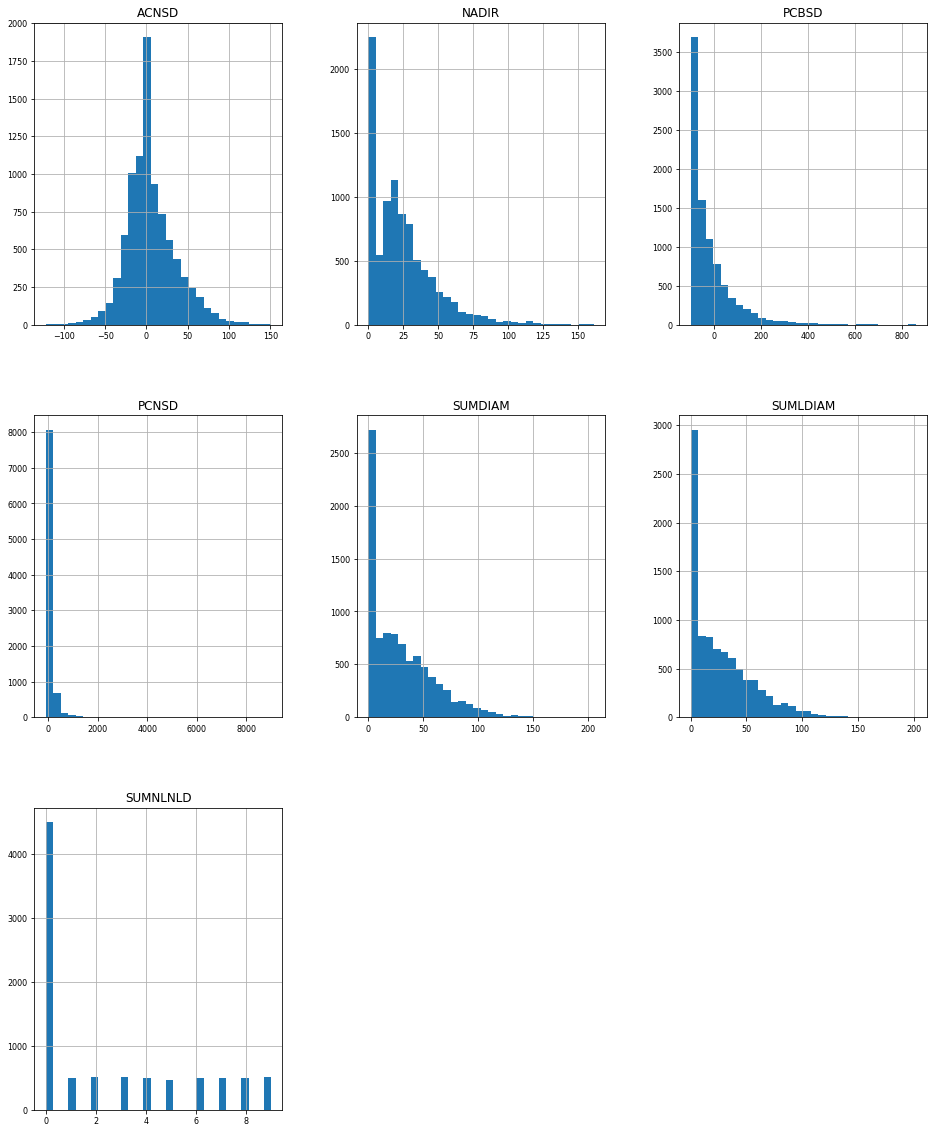

In [7]:
traindf.hist(figsize=(16, 20)
        , bins=30
        , xlabelsize=8
        , ylabelsize=8)

### - check for confounding

### - check for multicollinearity

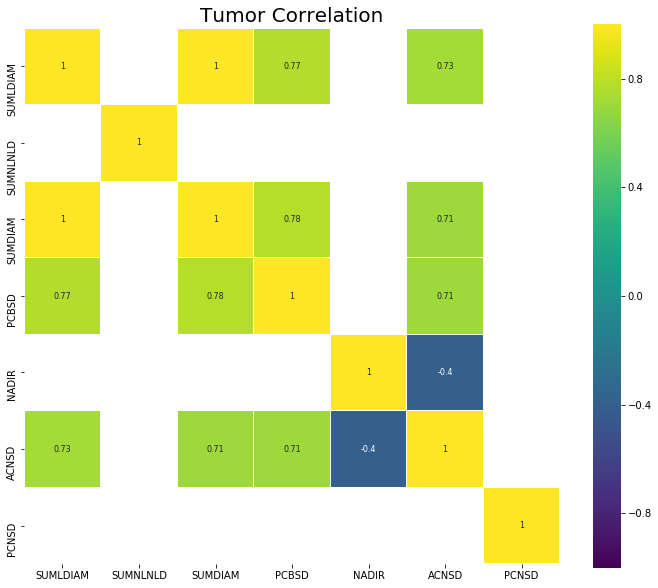

In [8]:
myutil.corr_matrix(traindf)

SUMLDAM dependent of PCBSD,
PCBSD looks dependent on SUMDIAM, but these are probably okay to keep

## 5. Split, pre-process

In [9]:
traindf.shape,traindf.shape[0]*.15

((9000, 8), 1350.0)

In [10]:
X_tr, X_ts, y_tr, y_ts = train_test_split(traindf.iloc[:,0:7]
                                          , traindf['TRGRESP']
                                          , random_state=2019
                                          , stratify=traindf['TRGRESP']
                                          , test_size =0.15)


confirm stratification

In [11]:
print(y_tr.value_counts()/len(y_tr)) 
print(y_ts.value_counts()/len(y_ts))

PD    0.316209
PR    0.304967
CR    0.253464
SD    0.125359
Name: TRGRESP, dtype: float64
PD    0.316296
PR    0.305185
CR    0.253333
SD    0.125185
Name: TRGRESP, dtype: float64


scale

```
#not suitable for this data
minmaxscl=MinMaxScaler((0,1))
X_tr = minmaxscl.fit_transform(X_tr)
X_ts = minmaxscl.fit_transform(X_ts)```

In [12]:
X_tr=normalize(X_tr,norm='l2', axis=1)
X_ts=normalize(X_ts,norm='l2', axis=1)

## 6.  train/evaluate cv results

### random forest

In [13]:
%%time
grid_param = {
    'n_estimators': [400, 800, 1600]
    , 'criterion': ['gini', 'entropy']
    , 'bootstrap': [True, False]
    , 'max_depth': np.arange(3,5,1)
}
rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=2019)
                     , param_distributions=grid_param
                     , scoring='accuracy'
                     , cv=10
                     , n_jobs=-1)
rf.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(rf.best_params_,rf.best_score_))

Best Model
Parameters: {'n_estimators': 1600, 'max_depth': 4, 'criterion': 'gini', 'bootstrap': True}
       Acc: 0.9673202614379085
Wall time: 5min 20s


### SVC

In [14]:
%%time
grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'gamma':stats.expon(scale=0.01)

}
lsvc = RandomizedSearchCV(estimator=SVC()
                  , param_distributions=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_jobs=-1)
lsvc.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(lsvc.best_params_,lsvc.best_score_))

Best Model
Parameters: {'C': 1.1623307440773565, 'gamma': 0.05390130102040785, 'tol': 0.0001}
       Acc: 0.9092810457516339
Wall time: 55.7 s


### logistic regression

In [15]:
%%time
grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'solver': ['lbfgs','saga','newton-cg']
    , 'max_iter':[100,300,600]
}
lr = RandomizedSearchCV(estimator=LogisticRegression(penalty='l2',
                                               multi_class='multinomial')
                  , param_distributions=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_jobs=-1)
lr.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(lr.best_params_,lr.best_score_))

Best Model
Parameters: {'C': 2.5357733337277146, 'max_iter': 600, 'solver': 'saga', 'tol': 0.0001}
       Acc: 0.9356862745098039
Wall time: 8.43 s


### knn

In [16]:
%%time
grid_param = {
            'weights': ['uniform','distance']
            , 'p': [1,2]
}
kn = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors = 4
                                                 ,algorithm ='auto')
                  , param_grid=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_jobs=-1)
kn.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(kn.best_params_,kn.best_score_))

Best Model
Parameters: {'p': 1, 'weights': 'distance'}
       Acc: 0.9780392156862745
Wall time: 837 ms


### xgboost

In [17]:
%%time
grid_param = {
        'min_child_weight': [1, 5, 10]
        ,'gamma': [0.5, 1, 1.5, 2, 5]
        ,'subsample': [0.6, 0.8, 1.0]
        ,'colsample_bytree': [0.6, 0.8, 1.0]
        ,'max_depth': [2, 3, 4, 5]
        ,'learning_rate': [0.01,0.1]
        ,'n_estimators': [1000, 2000]
        ,'lambda':[3,4]
        }

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
xg = RandomizedSearchCV(XGBClassifier(objective='multi:softprob'
                                        , silent=True
                                        , nthread=6)
                                      , param_distributions=grid_param
                                      , n_iter=5
                                      , scoring='accuracy'
                                      , n_jobs=4
                                      , cv=skf.split(X_tr,y_tr)
                                      , verbose=3
                                      , random_state=2019)

xg.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(xg.best_params_,xg.best_score_))

Fitting 10 folds for each of 5 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.2min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  9.9min finished


Best Model
Parameters: {'subsample': 0.6, 'n_estimators': 2000, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'lambda': 3, 'gamma': 1, 'colsample_bytree': 1.0}
       Acc: 0.9854901960784314
Wall time: 10min 21s


In [18]:
%%time
models = [rf.best_estimator_
          , lsvc.best_estimator_
          , lr.best_estimator_
          , kn.best_estimator_
          , xg.best_estimator_
]


entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_tr, y_tr, scoring='accuracy', cv=10)
    for idx, accuracy in enumerate(accuracies):
        entries.append((model_name, idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model name', 'idx', 'accuracy'])

Wall time: 5min 42s


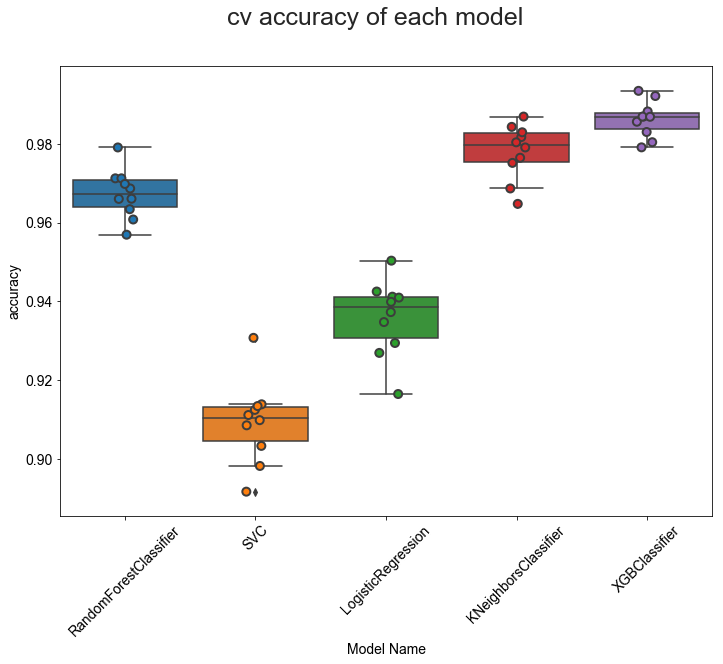

In [19]:
myutil.plot_model_performance(cv_df, t='cv')

## 7. test

In [20]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    clf=model.fit(X_tr,y_tr)
    y_pred=clf.predict(X_ts)
    acc=accuracy_score(y_ts, y_pred)
    entries.append((model_name, acc))
test_df = pd.DataFrame(entries, columns=['model name', 'accuracy'])

In [21]:
test_df

,model name,accuracy
0,RandomForestClassifier,0.962963
1,SVC,0.897037
2,LogisticRegression,0.920741
3,KNeighborsClassifier,0.977037
4,XGBClassifier,0.987407


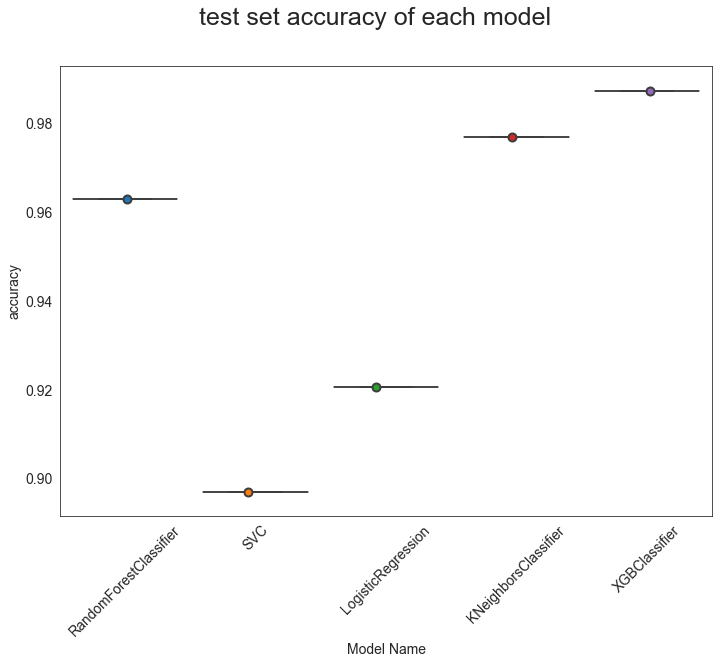

In [22]:
myutil.plot_model_performance(test_df, 'test set')

## Summary

The best model was the gradient boosting with accuracy of 98.7%. Took 10 min with 4 parallel threds and random sampling of hyperparameters.